# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.0.0+cu117


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [2]:
import sys
sys.path.append("..")

import clip.clip as clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32")

model, preprocess = clip.load(name="/datassd2/sswang/NFT_Search/CLIP/models/ViT-L-14-336px.pt", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [4]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7fa510256170>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("A picture of a triangular shape with a background of 2, covered in fur with a value of 6, without any earrings, wearing a hat with a value of 6, with eyes having a value of 14, not wearing any clothes, and without a mouth.")

tensor([[49406,   320,  1674,   539,   320,   924, 24981,  6448,   593,   320,
          5994,   539,   273,   267,  5603,   530,  9686,   593,   320,  4602,
           539,   277,   267,  2193,  1504,  9136,   267,  3309,   320,  3801,
           593,   320,  4602,   539,   277,   267,   593,  3095,  1977,   320,
          4602,   539,   272,   275,   267,   783,  3309,  1504,  7080,   267,
           537,  2193,   320,  4932,   269, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [40]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
	"Ape#0.png": "a picture of a futuristic Ape \n with silver hoop earring, \n orange background, \n robot fur, striped tee, discomfort mouth, \n and X eyes.",

    "Ape#1.png": "a picture of a robotic Ape  \n  wearing a Vietnam jacket, \nwith a big grin on its face, \n blue beams in its eyes, and \n an orange background.",

    "Ape#2.png": "a picture of a robotic Ape \n wearing a sea captain's hat, \n with 3D eyes, a bored expression \n with a cigarette in its mouth, and an \n aquamarine background.",

    "Ape#3.png": "a picture of a bored Cheetah Ape \n with its tongue out, \n wearing a bone necklace, \n and with purple background.",

    "Ape#4.png": "a picture of a Golden Brown Ape \n wearing a navy striped tee, \n with a party hat \n on its head, and its eyes closed, \n while making the phoneme L sound, \n set against a blue background.",

    "Ape#5.png": "a picture of a dumbfounded Brown Ape \n wearing a Bayc flipped brim hat \n and a Bayc T Red shirt, with X eyes, set \n against an army green background. ",

    "Ape#6.png": "a picture of a cream-furred ape \n wearing a tweed suit and an S&M hat, \n with bored expression \n on its mouth and crazy eyes, \n standing against \n a yellow background.",

    "Ape#7.png": "a picture of a golden brown-furred ape \n wearing a wool turtleneck \n and a stuntman helmet, \n with a bored expression \n on its mouth and angry eyes, \n standing against a gray background.",

    "Ape#8.png": "a picture of a zombie-furred ape \n wearing a beanie hat and \n a gold stud earring, \n with robot eyes and \n a bored expression on its mouth, \n standing against an \n aquamarine background.",

    "Ape#9.png": "a picture of a brown-furred ape \n wearing a seaman's hat and \n a stunt jacket, with \n a small grin on its mouth and sleepy eyes, \n wearing a silver stud earring, \n standing against a purple background.",
}


descriptions1 = {
	"Ape#0.png": "a picture of a futuristic Ape \n with silver hoop earring, \n robot fur, striped tee, discomfort mouth, \n and X eyes.",

    "Ape#1.png": "a picture of a robotic Ape  \n  wearing a Vietnam jacket, \nwith a big grin on its face, \n blue beams in its eyes.",

    "Ape#2.png": "a picture of a robotic Ape \n wearing a sea captain's hat, \n with 3D eyes, a bored expression \n with a cigarette in its mouth.",

    "Ape#3.png": "a picture of a bored Cheetah Ape \n with its tongue out, \n wearing a bone necklace.",

    "Ape#4.png": "a picture of a Golden Brown Ape \n wearing a navy striped tee, \n with a party hat \n on its head, and its eyes closed, \n while making the phoneme L sound.",

    "Ape#5.png": "a picture of a dumbfounded Brown Ape \n wearing a Bayc flipped brim hat \n and a Bayc T Red shirt, with X eyes. ",

    "Ape#6.png": "a picture of a cream-furred ape \n wearing a tweed suit and an S&M hat, \n with bored expression \n on its mouth and crazy eyes.",

    "Ape#7.png": "a picture of a golden brown-furred ape \n wearing a wool turtleneck \n and a stuntman helmet, \n with a bored expression \n on its mouth and angry eyes.",

    "Ape#8.png": "a picture of a zombie-furred ape \n wearing a beanie hat and \n a gold stud earring, \n with robot eyes and \n a bored expression on its mouth.",

    "Ape#9.png": "a picture of a brown-furred ape \n wearing a seaman's hat and \n a stunt jacket, with \n a small grin on its mouth and sleepy eyes, \n wearing a silver stud earring.",
}

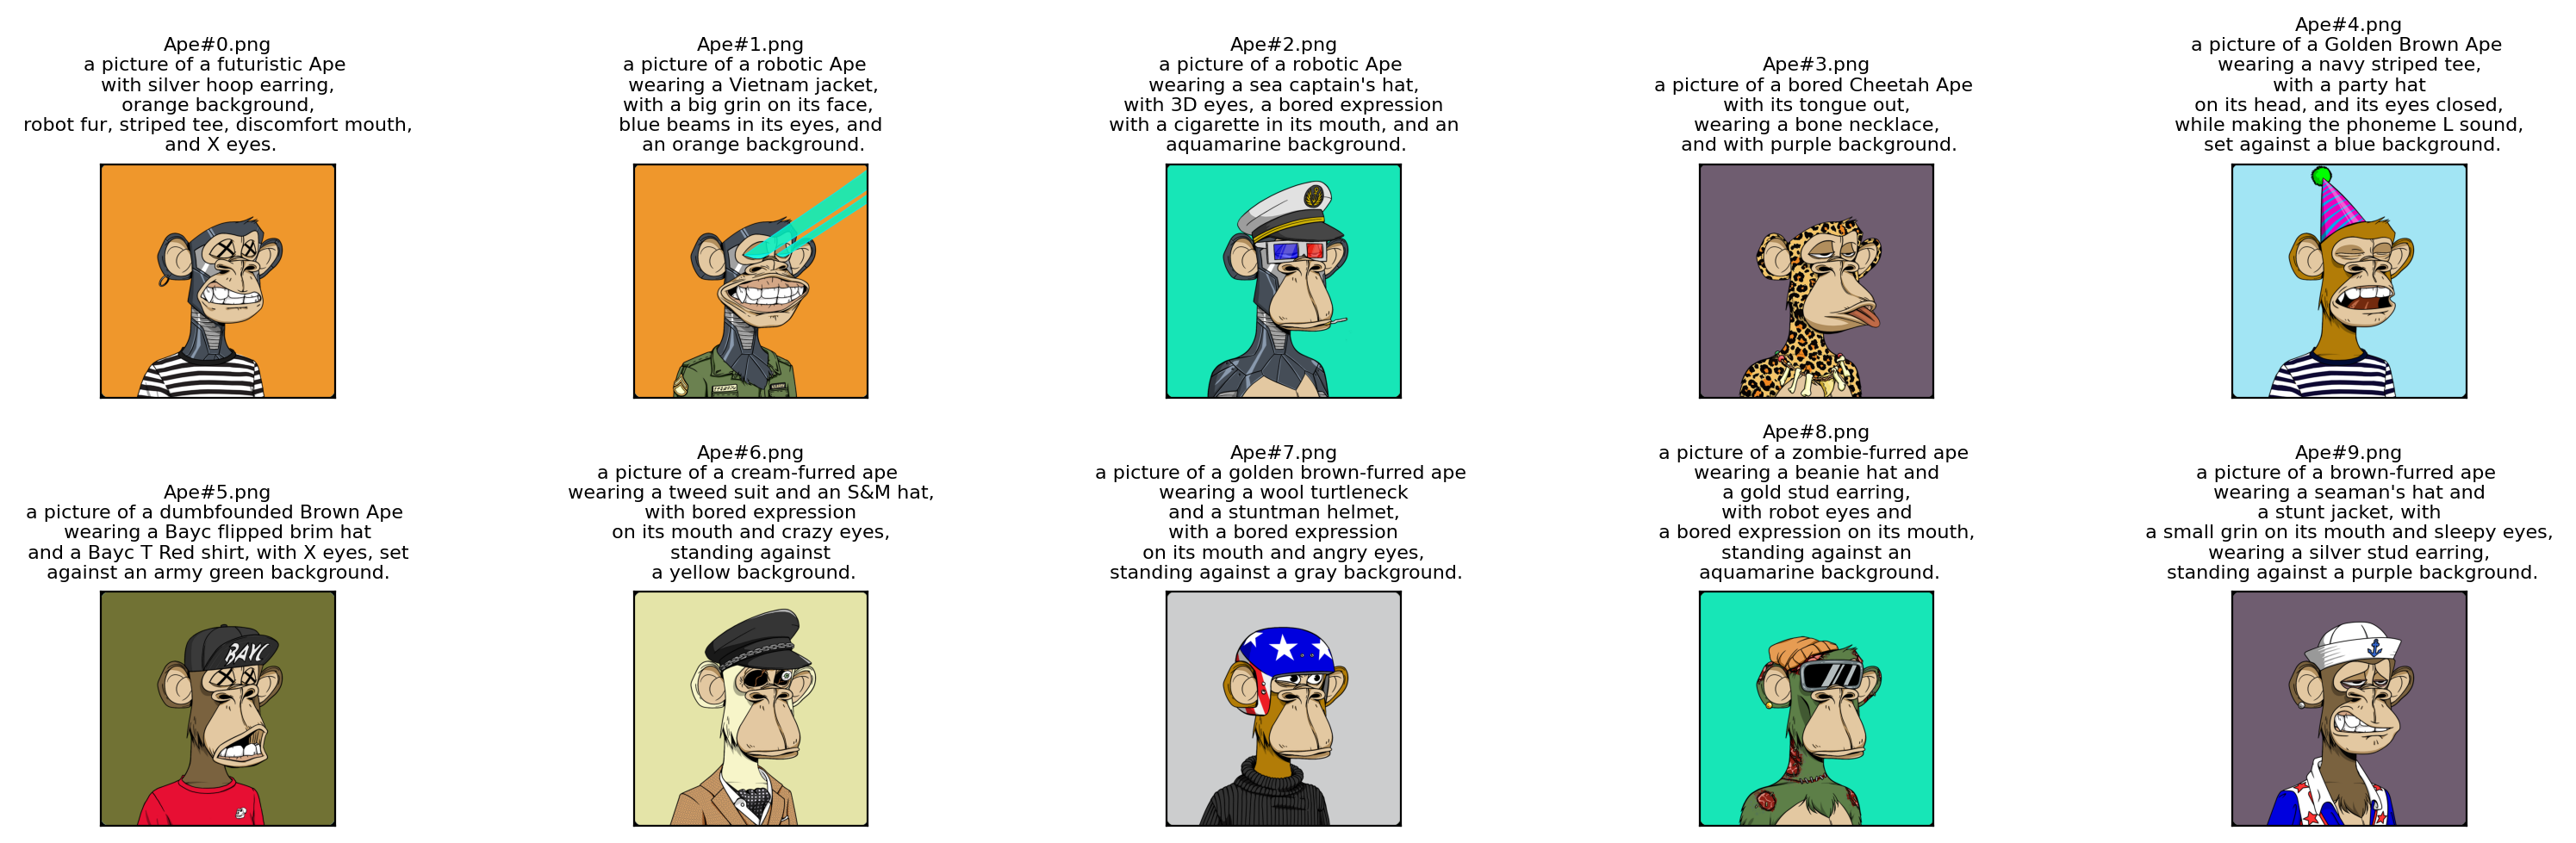

In [41]:
nas_base_path = "/sugonnas/NFT_Top1000"
BAYC_base_path = "/sugonnas/NFT_Top1000/Bored Ape Yacht Club/img/"
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

img_name_list = [str(index) + ".png" for index in range(10)]

for img in img_name_list:
    filename = "Ape#" + img
    if filename not in descriptions.keys():
        continue

    image = Image.open(os.path.join(BAYC_base_path, img)).convert("RGB")
  
    plt.subplot(2, 5, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[filename]}", fontsize=8)
    plt.xticks([])
    plt.yticks([])

    # 数组加入原图
    original_images.append(image)
    # 加入被处理后的图像
    images.append(preprocess(image))
    texts.append(descriptions[filename])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [42]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [43]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [44]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

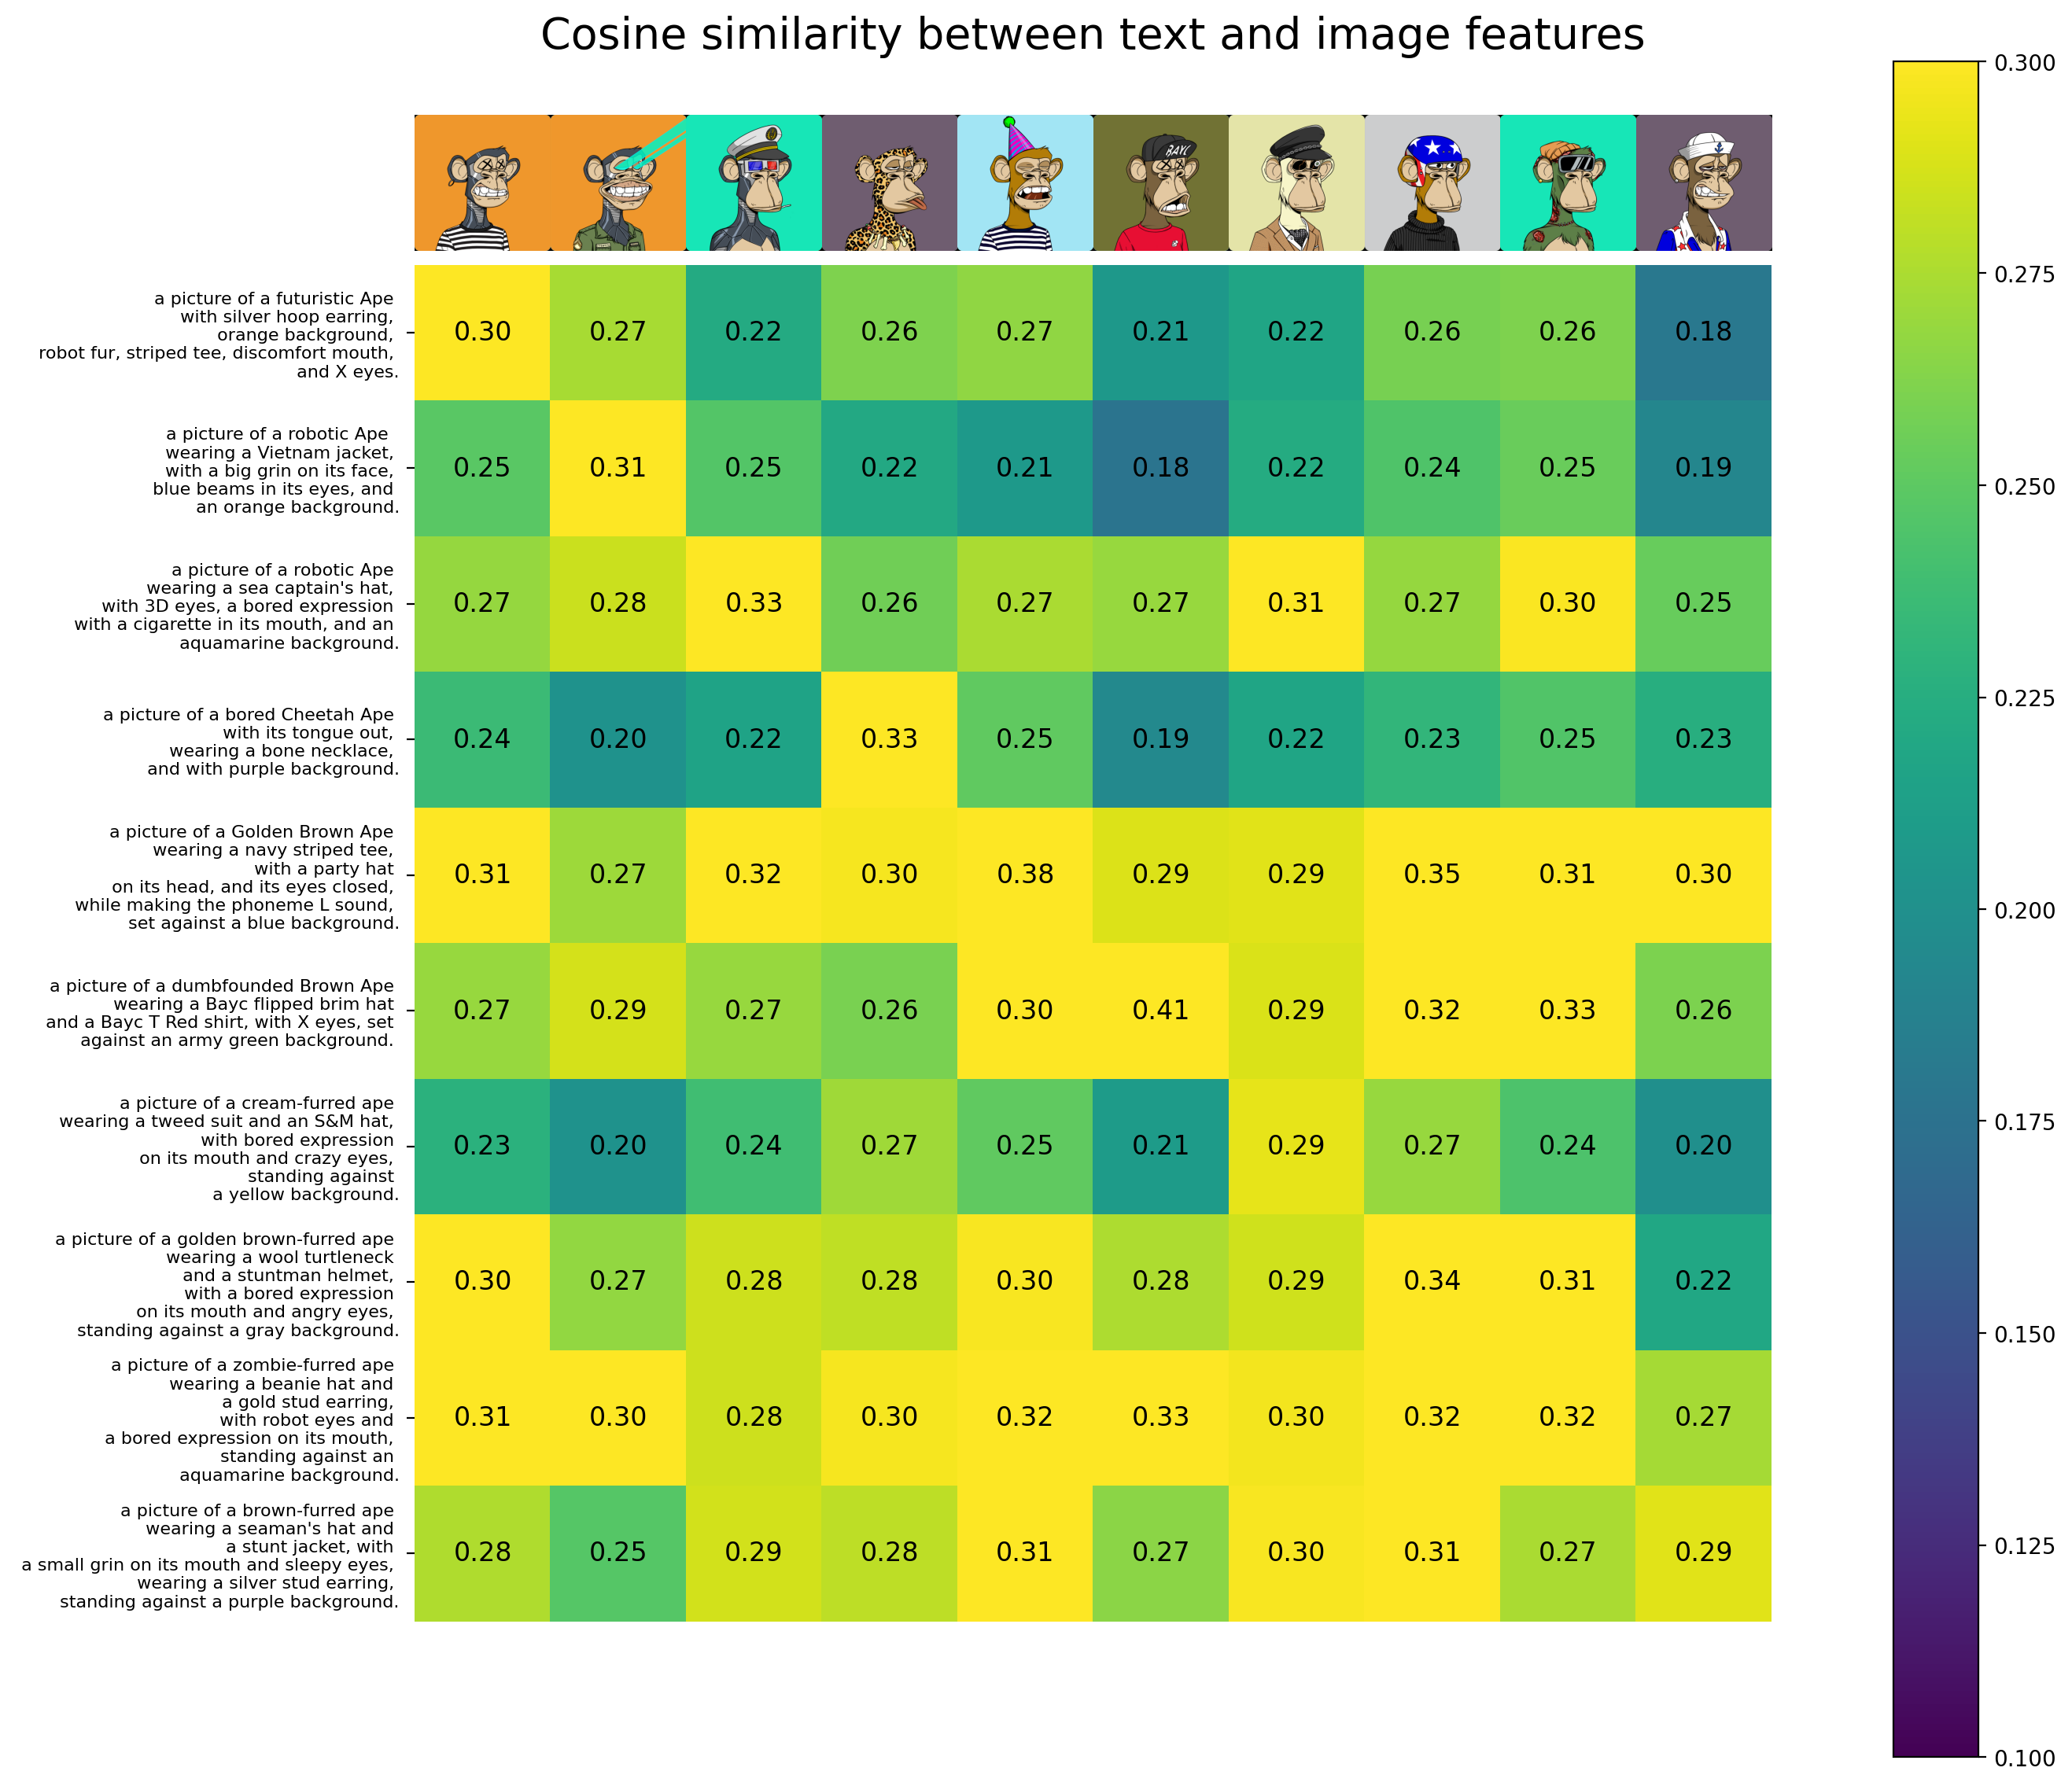

In [54]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.colorbar()
plt.yticks(range(count), texts, fontsize=8)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [46]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [47]:
# for label in cifar100.classes:
    
#     print(label)

print(cifar100.classes)
print(type(cifar100.classes))

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [48]:
BAYC_classes = {
        "0": "Earring of Silver Hoop",
        "1": "Background of Orange",
        "2": "Fur of Robot",
        "3": "Clothes of Striped Tee",
        "4": "Mouth of Discomfort",
        "5": "Eyes of X Eyes",
        "6": "Mouth of Grin",
        "7": "Clothes of Vietnam Jacket",
        "8": "Eyes of Blue Beams",
        "9": "Clothes of Navy Striped Tee",
        "10": "Background of Aquamarine",
        "11": "Hat of Bayc Hat Red",
        "12": "Fur of Dmt",
        "13": "Eyes of Eyepatch",
        "14": "Mouth of Bored",
        "15": "Background of Yellow",
        "16": "Mouth of Bored Cigarette",
        "17": "Hat of Party Hat 2",
        "18": "Fur of Dark Brown",
        "19": "Eyes of Wide Eyed",
        "20": "Eyes of Hypnotized",
        "21": "Mouth of Phoneme  ooo",
        "22": "Fur of Brown",
        "23": "Clothes of Toga",
        "24": "Hat of Prussian Helmet",
        "25": "Hat of Fez",
        "26": "Mouth of Bored Unshaven",
        "27": "Eyes of Robot",
        "28": "Eyes of Coins",
        "29": "Clothes of Prison Jumpsuit",
        "30": "Mouth of Small Grin",
        "31": "Background of Gray",
        "32": "Clothes of Tweed Suit",
        "33": "Fur of Cheetah",
        "34": "Earring of Silver Stud",
        "35": "Hat of Halo",
        "36": "Background of Purple",
        "37": "Fur of Black",
        "38": "Clothes of Sailor Shirt",
        "39": "Fur of Cream",
        "40": "Hat of Cowboy Hat",
        "41": "Fur of White",
        "42": "Clothes of Smoking Jacket",
        "43": "Mouth of Bored Unshaven Cigarette",
        "44": "Eyes of Angry",
        "45": "Fur of Red",
        "46": "Background of New Punk Blue",
        "47": "Hat of Seaman's Hat",
        "48": "Clothes of Biker Vest",
        "49": "Fur of Gray",
        "50": "Mouth of Grin Diamond Grill",
        "51": "Hat of Army Hat",
        "52": "Eyes of Bored",
        "53": "Hat of Commie Hat",
        "54": "Mouth of Phoneme Oh",
        "55": "Hat of Fisherman's Hat",
        "56": "Background of Army Green",
        "57": "Clothes of Puffy Vest",
        "58": "Hat of Irish Boho",
        "59": "Eyes of Crazy",
        "60": "Fur of Death Bot",
        "61": "Fur of Pink",
        "62": "Hat of Police Motorcycle Helmet",
        "63": "Clothes of Lumberjack Shirt",
        "64": "Eyes of Bloodshot",
        "65": "Eyes of Sleepy",
        "66": "Clothes of Tuxedo Tee",
        "67": "Clothes of Sleeveless T",
        "68": "Eyes of Scumbag",
        "69": "Mouth of Bored Bubblegum",
        "70": "Mouth of Phoneme L",
        "71": "Fur of Tan",
        "72": "Background of Blue",
        "73": "Hat of Faux Hawk",
        "74": "Clothes of Hawaiian",
        "75": "Clothes of Bayc T Black",
        "76": "Eyes of Zombie",
        "77": "Earring of Diamond Stud",
        "78": "Clothes of Stunt Jacket",
        "79": "Hat of Bowler",
        "80": "Mouth of Bored Party Horn",
        "81": "Clothes of Service",
        "82": "Hat of Short Mohawk",
        "83": "Mouth of Grin Gold Grill",
        "84": "Hat of Beanie",
        "85": "Eyes of 3d",
        "86": "Clothes of Bayc T Red",
        "87": "Fur of Golden Brown",
        "88": "Mouth of Rage",
        "89": "Hat of Party Hat 1",
        "90": "Earring of Gold Stud",
        "91": "Clothes of Leather Punk Jacket",
        "92": "Mouth of Dumbfounded",
        "93": "Fur of Blue",
        "94": "Clothes of Lab Coat",
        "95": "Clothes of Leather Jacket",
        "96": "Mouth of Bored Dagger",
        "97": "Clothes of Black T",
        "98": "Clothes of Work Vest",
        "99": "Hat of Vietnam Era Helmet",
        "100": "Hat of Sea Captain's Hat",
        "101": "Mouth of Phoneme Vuh",
        "102": "Eyes of Closed",
        "103": "Hat of Baby's Bonnet",
        "104": "Earring of Gold Hoop",
        "105": "Eyes of Blindfold",
        "106": "Hat of Bayc Flipped Brim",
        "107": "Mouth of Bored Pipe",
        "108": "Eyes of Holographic",
        "109": "Hat of Laurel Wreath",
        "110": "Clothes of Guayabera",
        "111": "Mouth of Tongue Out",
        "112": "Earring of Cross",
        "113": "Eyes of Sad",
        "114": "Hat of Stuntman Helmet",
        "115": "Hat of Ww2 Pilot Helm",
        "116": "Mouth of Bored Unshaven Party horn",
        "117": "Mouth of Jovial",
        "118": "Clothes of Bone Necklace",
        "119": "Clothes of Bandolier",
        "120": "Hat of Bandana Blue",
        "121": "Clothes of Cowboy Shirt",
        "122": "Hat of Bunny Ears",
        "123": "Clothes of Bone Tee",
        "124": "Hat of Spinner Hat",
        "125": "Clothes of Tie Dye",
        "126": "Clothes of Blue Dress",
        "127": "Mouth of Phoneme Wah",
        "128": "Eyes of Sunglasses",
        "129": "Hat of S&m Hat",
        "130": "Clothes of Black Holes T",
        "131": "Eyes of Heart",
        "132": "Clothes of Space Suit",
        "133": "Mouth of Bored Kazoo",
        "134": "Fur of Zombie",
        "135": "Clothes of Tanktop",
        "136": "Mouth of Bored Cigar",
        "137": "Clothes of Prom Dress",
        "138": "Fur of Noise",
        "139": "Mouth of Bored Unshaven Pipe",
        "140": "Mouth of Bored Unshaven Kazoo",
        "141": "Clothes of Rainbow Suspenders",
        "142": "Clothes of Sleeveless Logo T",
        "143": "Fur of Trippy",
        "144": "Clothes of Admirals Coat",
        "145": "Hat of Horns",
        "146": "Mouth of Bored Unshaven Dagger",
        "147": "Hat of Bayc Hat Black",
        "148": "Hat of Girl's Hair Pink",
        "149": "Clothes of Kings Robe",
        "150": "Clothes of Caveman Pelt",
        "151": "Eyes of Laser Eyes",
        "152": "Hat of Girl's Hair Short",
        "153": "Hat of Safari",
        "154": "Eyes of Cyborg",
        "155": "Hat of Sushi Chef Headband",
        "156": "Clothes of Pimp Coat",
        "157": "Hat of King's Crown",
        "158": "Mouth of Grin Multicolored",
        "159": "Mouth of Bored Unshaven Cigar",
        "160": "Mouth of Bored Pizza",
        "161": "Clothes of Wool Turtleneck",
        "162": "Mouth of Bored Unshaven Bubblegum",
        "163": "Hat of Trippy Captain's Hat",
        "164": "Clothes of Hip Hop",
        "165": "Clothes of Black Suit",
        "166": "Mouth of Bored Unshaven Pizza",
        "167": "Fur of Solid Gold"
    }

BAYC_class_list = []
for value in BAYC_classes.values():
    BAYC_class_list.append(value)

In [49]:
text_descriptions = [f"This is a photo of a {label}" for label in BAYC_class_list]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [50]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [51]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(10, dim=-1)

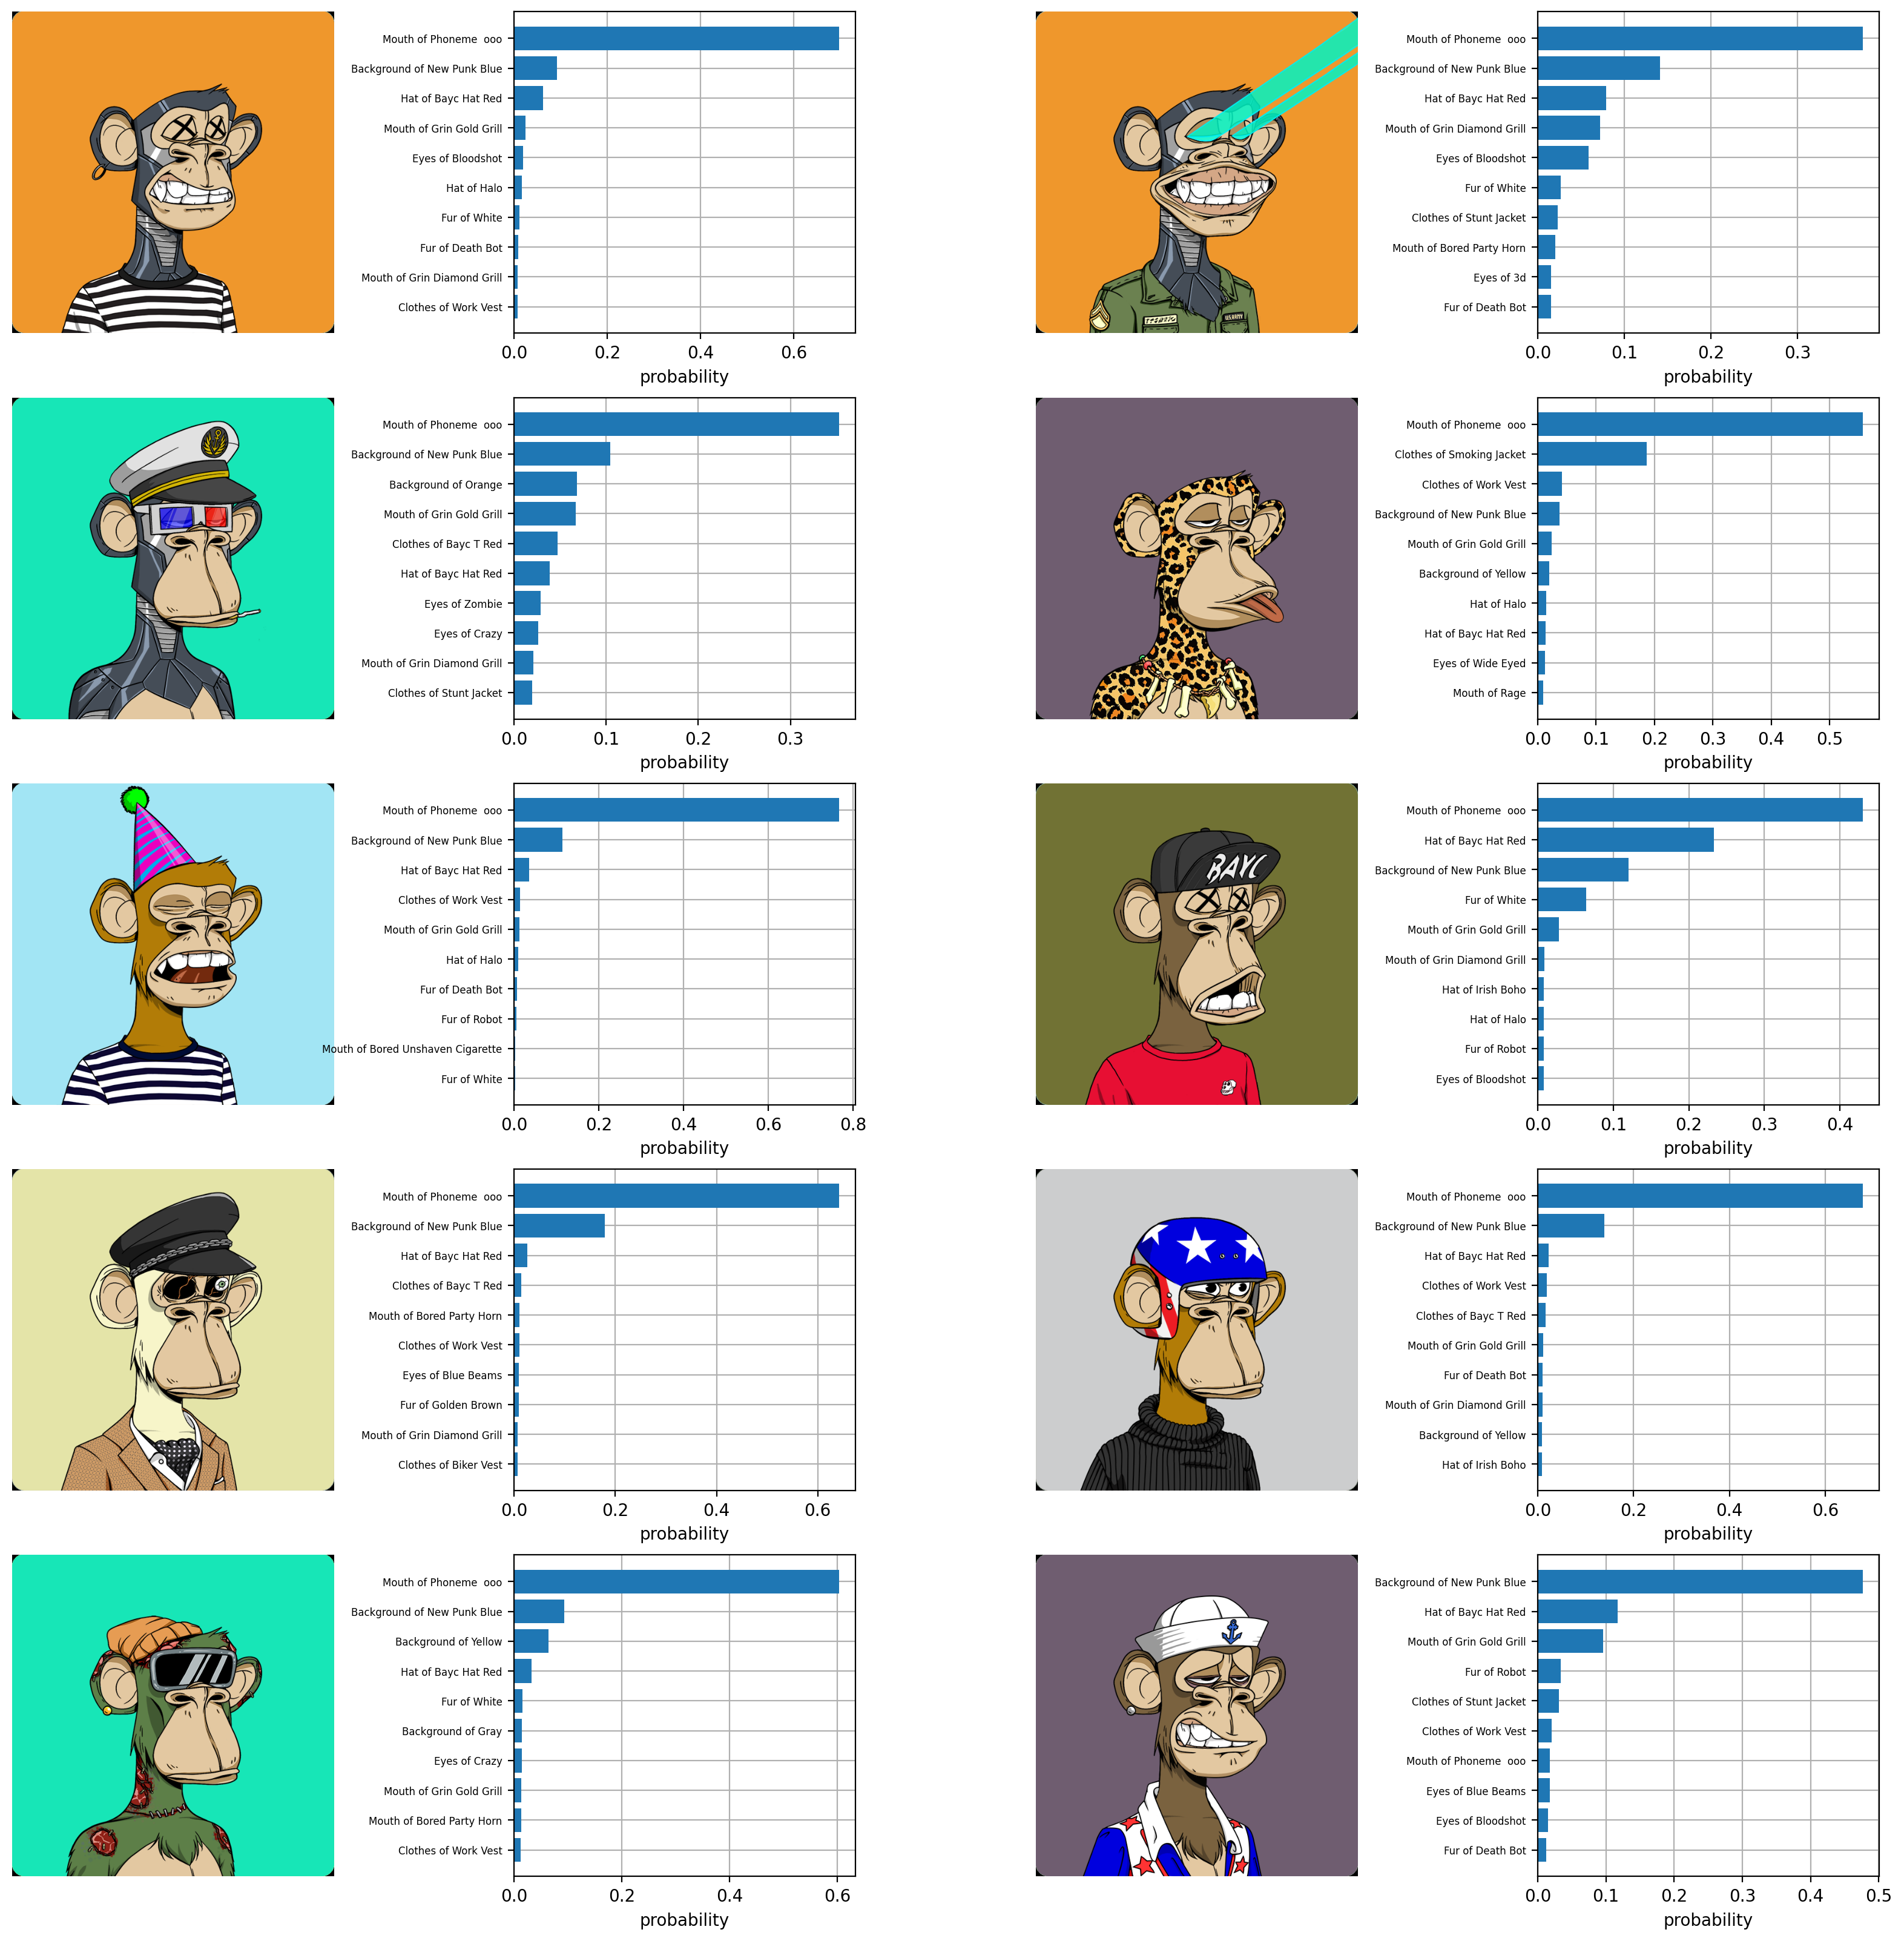

In [52]:
plt.figure(figsize=(20, 20))

for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1]) #生成一个从 0 到 99 的数组，用于表示每个类别的索引
    plt.grid() # 添加网格
    plt.barh(y, top_probs[i]) # 水平条形图 横坐标是分类概率，纵坐标是 CIFAR-100 数据集中的 100 个类别
    plt.gca().invert_yaxis() # 函数将纵坐标反向
    plt.gca().set_axisbelow(True) # 将网格线放在条形图下方
    # 设置纵坐标刻度线和标签 推导式生成标签，其中 top_labels 是一个张量，包含每个图像的预测类别
    plt.yticks(y, [BAYC_class_list[index] for index in top_labels[i].numpy()], fontsize=6) 
    plt.xlabel("probability") # 函数为条形图添加一个概率标签。

plt.subplots_adjust(wspace=0.5) # 调整子图之间的间距
plt.show() # 函数显示图形

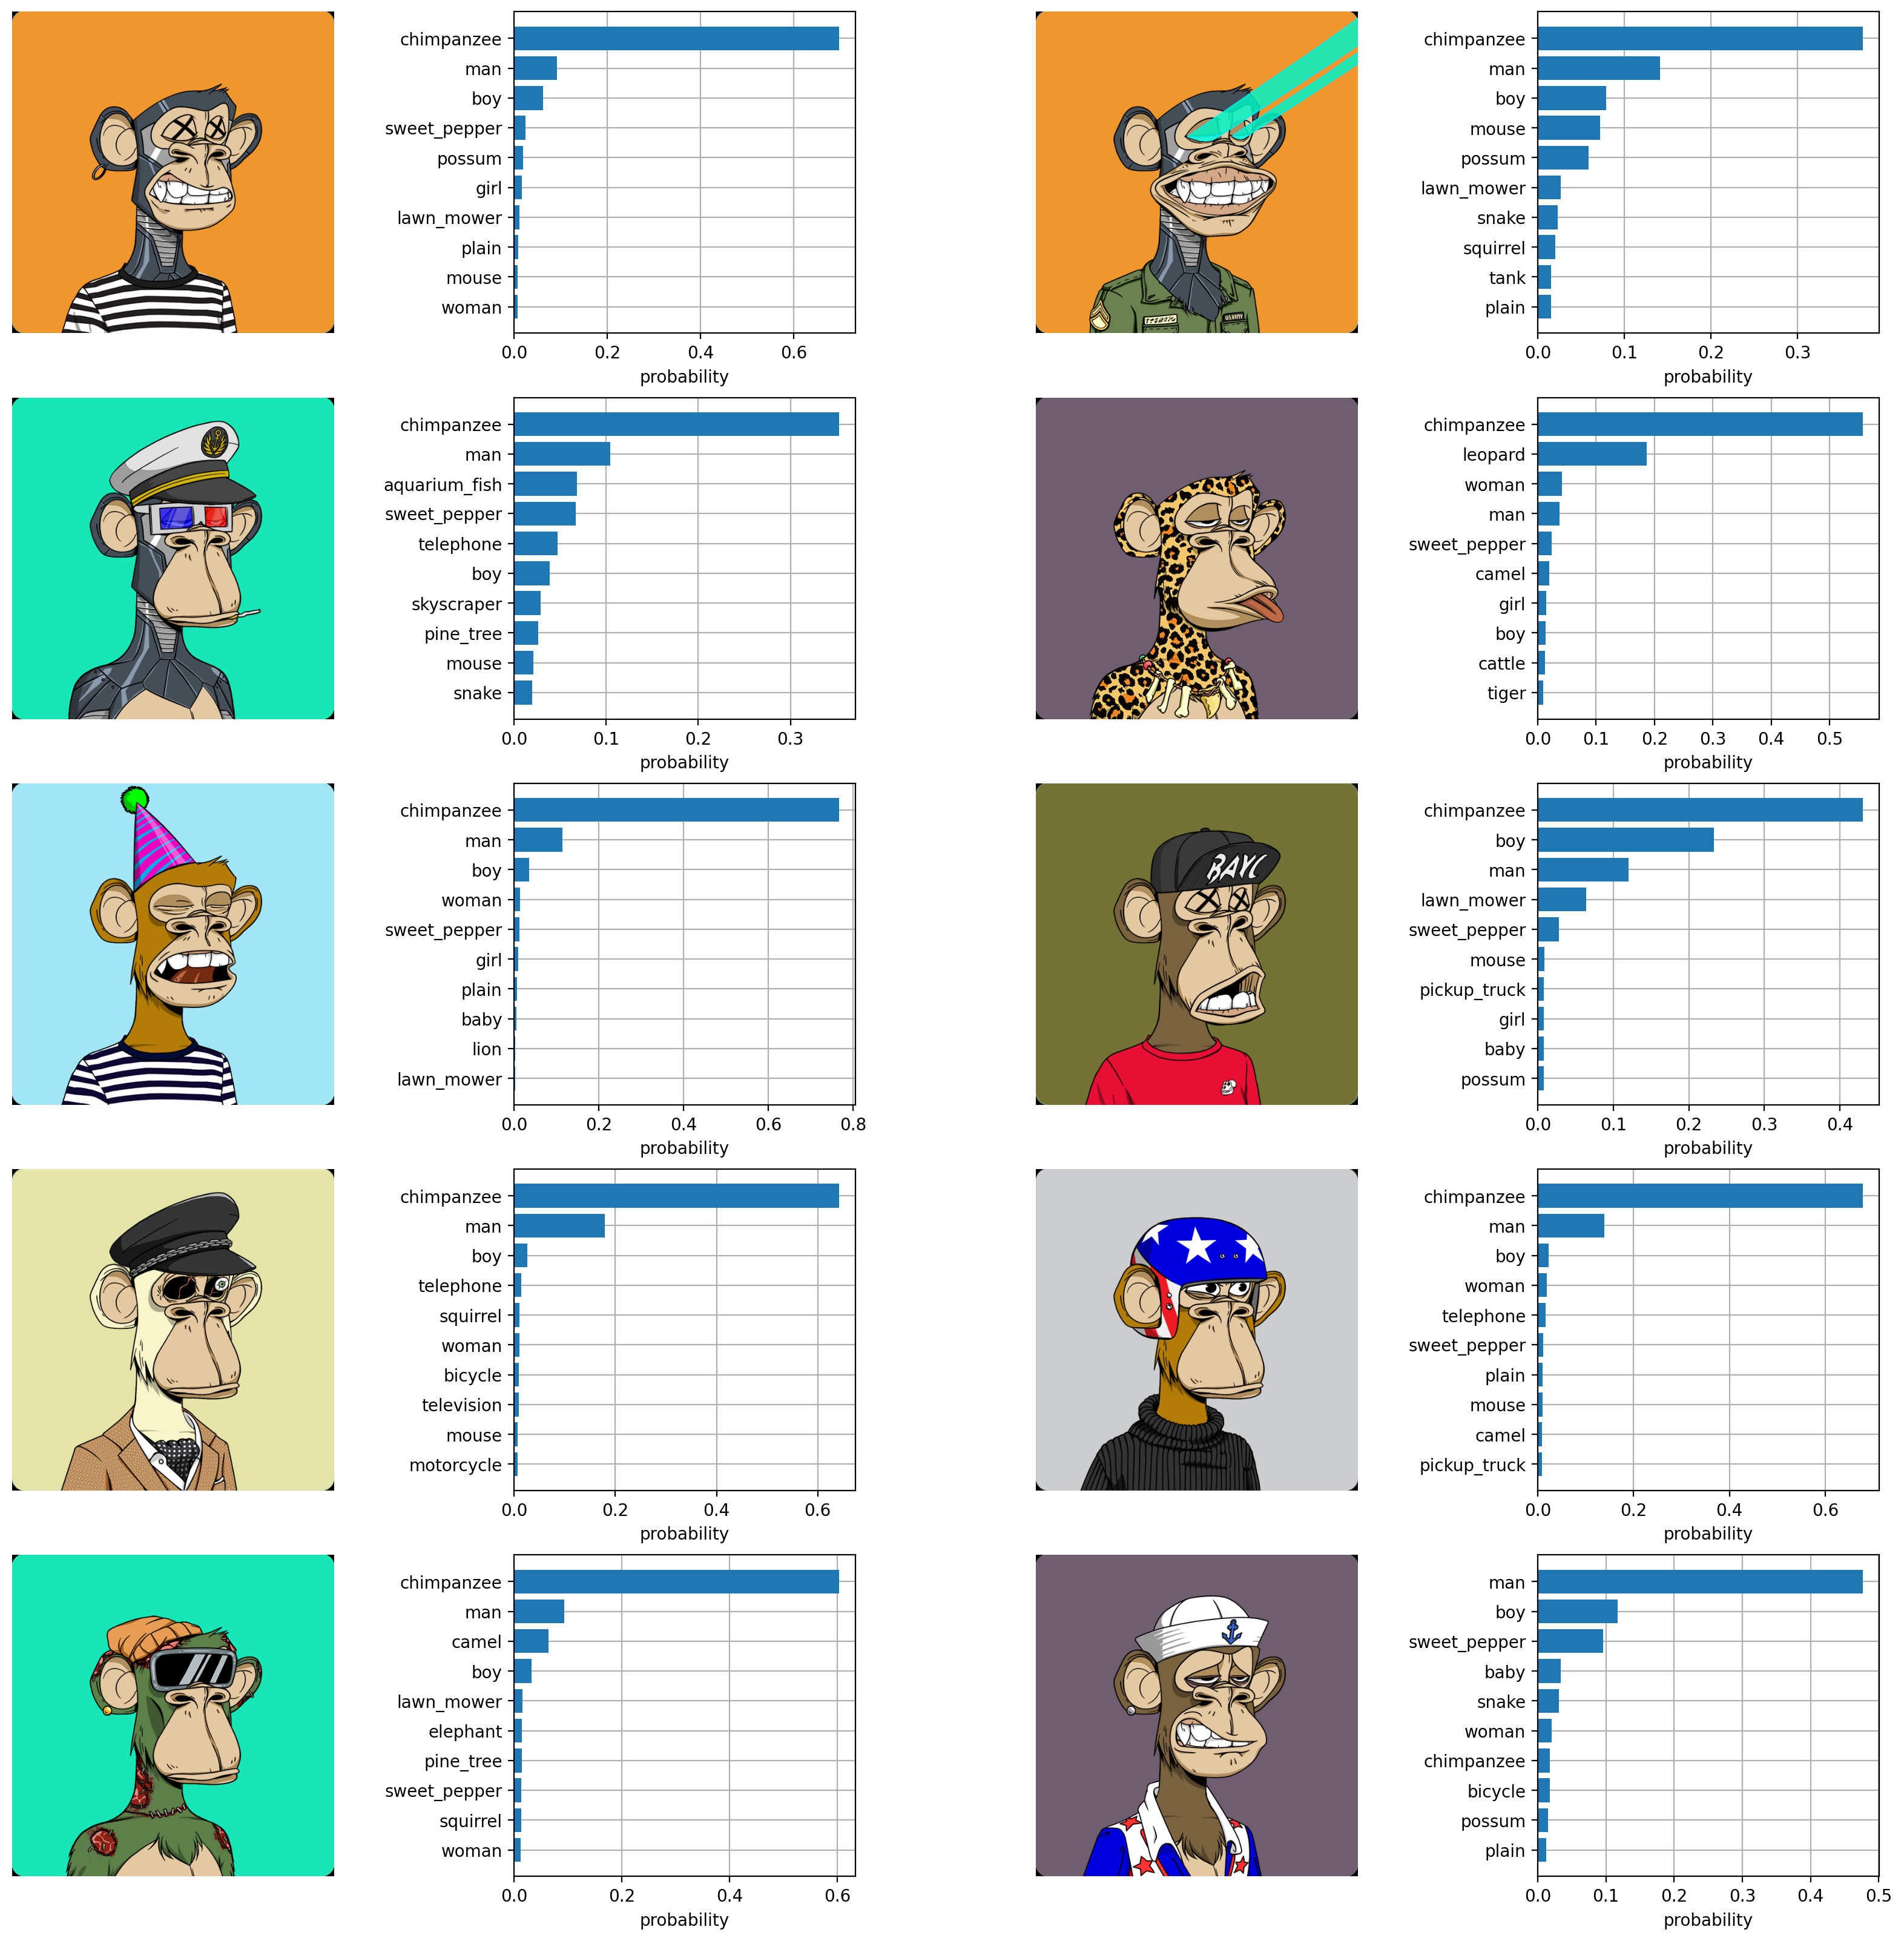

In [53]:
plt.figure(figsize=(20, 20))

for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1]) #生成一个从 0 到 99 的数组，用于表示每个类别的索引
    plt.grid() # 添加网格
    plt.barh(y, top_probs[i]) # 水平条形图 横坐标是分类概率，纵坐标是 CIFAR-100 数据集中的 100 个类别
    plt.gca().invert_yaxis() # 函数将纵坐标反向
    plt.gca().set_axisbelow(True) # 将网格线放在条形图下方
    # 设置纵坐标刻度线和标签 推导式生成标签，其中 top_labels 是一个张量，包含每个图像的预测类别
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()]) 
    plt.xlabel("probability") # 函数为条形图添加一个概率标签。

plt.subplots_adjust(wspace=0.5) # 调整子图之间的间距
plt.show() # 函数显示图形